In [24]:
from __future__ import division
import numpy as np
from astroquery.skyview import SkyView
from matplotlib import colors, cm, pyplot as plt
from scipy.optimize import curve_fit

In [25]:
#Define a Gaussian function that will be used for fitting to our data
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [26]:
#SkyView.list_surveys() #To list various archives available for download

#Download GOODS North HST ACS F435W fits image of 512x512 pixels centered at RA=12:36:49.7, Dec=62:18:52.1. F606W, F775W, etc. can be accessed by changing 'ACS B' to 'ACS V', 'ACS I', etc.
hdulist = SkyView.get_images(position='12:36:49.7,62:18:52.1',survey='GOODS: HST ACS B',pixels='512,512',coordinates='J2000')
hdu1 = hdulist[0]                                                                  #Take first element in list of HDU lists
hdf = hdu1[0]                                                                      #First HDU in HDU list
hdfarr = hdf.data                                                                  #Get data from HDU

In [27]:
#Freedman-Diaconis rule: bin size=2*IQR/n^(1/3). Designed to minimize the difference between the area under 
#the empirical probability distribution and the area under the theoretical probability distribution. 
#IQR= InterQuartile Range, n=number of samples
q75,q25=np.percentile(hdfarr,[75,25])                                              #Calculate 75th and 25th percentile
iqr = q75-q25                                                                      #Calculate IQR
bwidth = 2*iqr/(hdfarr.size**(1./3))                                               #Apply F-D rule
nbins = int((np.amax(hdfarr)-np.amin(hdfarr))/bwidth)                              #Convert to number of bins
hist, bin_edges = np.histogram(hdfarr,bins=nbins)                                  #Generate histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2                                   #Find bin centers
#Initial guesses for fitting the Gaussian for A, mu, and sigma. 'A' will be close to the peak of the histogram, 
#mu close to the average of the data, and sigma will be close to the standard deviation of the data.
p0 = [np.amax(hist),np.average(hdfarr),np.std(hdfarr)]
#Fit the data to our defined Gaussian using our initial guess and set a maximum number of function evaluations 
#before the termination (maxfev), using the default Levenberg-Marquardt least squares fitting algorithm, good 
#for nonlinear functions. The output is the best-fit, least-squares input parameters for the function and 
#the covariance matrix of those parameters which can be used for assessing goodness of fit. 
coeffs, covar = curve_fit(gauss, bin_centers, hist, p0=p0, maxfev=10000)

In [28]:
newx = np.arange(min(bin_centers),max(bin_centers),.00001)                      #Define a new finer input array for our fitted function
hist_fit = gauss(newx, *coeffs)                                                 #Create the output of our fitted Gaussian
fig = plt.figure(tight_layout=True)                                             #Prepare to plot
ax = fig.add_subplot(111,xlabel=r'Flux [counts s$^{-1}$]',ylabel='N')           #Make axes for data+fit histograms
ax.plot(bin_centers, hist, label='Image data')                                  #Plot data histogram
ax.plot(newx, hist_fit, label='Gauss Fit')                                      #Plot fit histogram
ax.legend(loc=1,prop={'size':12})                                               #Create a legend
#Add text and lines for comparing averages of data and fit
ax.text(.02,.95,r'$Data_{{avg}}={:.3e}$'.format(np.average(hdfarr)),fontsize=12,fontweight='bold',horizontalalignment='left',verticalalignment='center',transform=ax.transAxes)
ax.text(.02,.85,r'$Gauss_{{\mu}}={:.3e}$'.format(coeffs[1]),fontsize=12,fontweight='bold',horizontalalignment='left',verticalalignment='center',transform=ax.transAxes)
ax.axvline(x=coeffs[1],ls='--',c='k')
ax.axvline(x=np.average(hdfarr),ls='-.',c='k')
ax.set_xlim(-4*coeffs[2],6*coeffs[2])                                           #Set x/y limits
ax.set_ylim(0,1.1*np.amax(hist))

(0, 4902.700000000001)

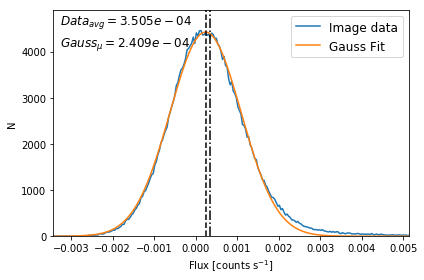

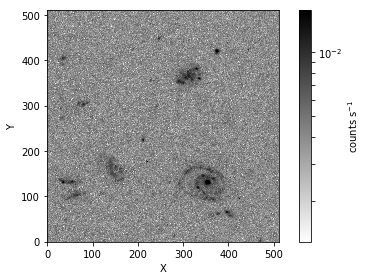

In [29]:
fig2 = plt.figure(tight_layout=True)                                            #Get ready to plot the image
ax2 = fig2.add_subplot(111,xlabel='X',ylabel='Y')                               #Axes for image
vmin,vmax = -3*coeffs[2]-np.amin(hdfarr), 14*coeffs[2]-np.amin(hdfarr)          #Set contrast limits
log = colors.LogNorm(vmin,vmax)                                                 #Make a log scale for the display
cax = ax2.imshow(hdfarr-np.amin(hdfarr),cmap=cm.gray_r,origin='lower',norm=log) #Plot the image
fig2.colorbar(cax,label=r'counts s$^{-1}$')                                     #Add a colorbar
plt.show()                                                                      #Admire your plots